In [2]:
import torch as t
import matplotlib.pyplot as plt
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import importlib
import Systems as Systems
import Plotting as Plotting
import Controls as Controls
import Evolvers as Evolvers

from tqdm import tqdm
from time import time

In [3]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Controls)
importlib.reload(Evolvers)

<module 'Evolvers' from 'c:\\Users\\jv97\\Desktop\\github\\Quantum-Optimal-Control\\scripts\\Evolvers.py'>

In [4]:
params_dict = {
"T": 		30,
"NTrot": 	1000,
"q_max": 	10,
"lr": 		3e-4,
"Scheduler":	True,
"loss_funcs":	["C1_gate"],
"subNHilbert":  30,
"dim":          "2d",

"_SystemComments":"The following are the specifications for the 1DFlensmon, with respectively: 0.997*pi, 2*pi*10GHz and EJ/100",

"phi_ext": 3.132167875629024,
"EJ": 		62.83185307179586,
"EC": 		0.6283185307179586,

"decline_end":	10.0,
"ascend_start":	20.0,
"level":	1.0,
"envelope_amp":	0.2397,
"detuning":	0.2956,
"phase":	1.7529
}

class QTrotter(Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.QTrotter, Plotting.Plotter):
    def __init__(self,params_dict):
        self.params_dict = params_dict
        # self.alphas = alphas
        # self.control = control
        super().__init__()
        return

    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
QT = QTrotter(params_dict)

I added a factor half to the cosines


In [5]:
import math 
import torch
from torch import Tensor
# from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma*self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -0.5*(t.square((z - self.mu)/self.sigma) + t.log(2*t.pi*t.square(self.sigma)))


In [262]:
class model(t.nn.Module,Systems.Periodic_System, Evolvers.SavedBasis):
    def __init__(self,params_dict):
        super().__init__()
        self.beta = 1.0
        self.params_dict = params_dict

        self.ReLU = t.nn.ReLU()
        self.heights = t.nn.parameter.Parameter(self.init_heights())
        self.prior_sigma = t.log(t.ones(998)/500)
        self.log_sigma = t.nn.parameter.Parameter(self.prior_sigma.clone())

        super(t.nn.Module,self).__init__()
        self.prepare_target_gate_adj()
    
    def init_heights(self):
        time = t.linspace(0,30,1000)[1:-1]
        alphas = t.sin(time)*t.exp(-(time-15)**2/10) + t.exp(-time/3) + t.exp(-(30 - time)/3)
        alphas = alphas - alphas.min()
        alphas = alphas/alphas.max()/2
        alphas = alphas + 0.5
        return self.restrict_output(self.restrict_diff(alphas)[1:-1],0.5,1)
        # return time*(time-30)/500 + 1

    def restrict_output(self,inp,Min,Max):
        return self.ReLU(inp - Min) - self.ReLU(inp - Max) + Min
    
    def forward(self):
        qz = ReparameterizedDiagonalGaussian(self.restrict_output(self.heights,0.5,1.0), self.log_sigma)
        alphas = qz.rsample()

        pz = ReparameterizedDiagonalGaussian(self.restrict_output(self.heights.detach().clone(),0.5,1.0),self.prior_sigma)

        log_pz = pz.log_prob(alphas).sum()
        log_qz = qz.log_prob(alphas).sum()
        
        # loss_kl = - self.beta*( log_qz - log_pz )
        loss_kl = self.beta*0.5*(t.square(self.prior_sigma.exp()/self.log_sigma.exp()) - 1 + 2*(self.log_sigma - self.prior_sigma)).mean()

        alphas = self.restrict_diff(alphas)
        H = self.get_H(alphas=alphas)
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        U = t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))

        return U, loss_kl
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
    
    def prepare_target_gate_adj(self):
        tmp = t.eye(self.subNHilbert,dtype=t.cfloat)
        tmp[0,0] = 0
        tmp[0,1] = 1
        tmp[1,0] = 1
        tmp[1,1] = 0
        self.target_gate_adj = tmp.adjoint()
        self.basis_change = self.basis.adjoint()@self.eigvecs[:,:self.subNHilbert]
    
    def C1_gate(self,U):
        transformed = self.basis_change.adjoint()@U@self.basis_change
        dim = 2
        return 1 - 1/dim**2*t.square(t.abs(t.trace(self.target_gate_adj[:dim]@transformed[:,:dim])))
    
    def restrict_diff(self,heights):
        max_diff = 0.01
        out = t.zeros(heights.shape[0])
        out[0] = heights[0]
        for i in range(heights.shape[0]-1):
            diff = heights[i+1] - out[i]
            out[i+1] = out[i] + self.restrict_output(diff,0,max_diff) + self.restrict_output(diff,-max_diff,0)
        one = t.tensor([1.])
        return t.concat([one,self.restrict_output(out,0.5,1),one])

obj = model(params_dict)

I added a factor half to the cosines


In [263]:
def lr_func(epoch):
    return 0.9/(1+((epoch-15)/5)**2) + 0.1

optimizer = t.optim.Adam(obj.parameters(), lr=1e-3)
scheduler = t.optim.lr_scheduler.LambdaLR(optimizer,lr_func)

In [264]:
kl_losses = []
gate_losses = []
def train(Nepochs):
    for i in tqdm(range(Nepochs)):
        optimizer.zero_grad()
        U, loss_kl = obj()
        loss_gate = obj.C1_gate(U)
        loss = loss_gate + loss_kl
        loss.backward()
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            kl_losses.append(loss_kl.item())
            gate_losses.append(loss_gate.item())

In [265]:
train(200)

100%|██████████| 200/200 [08:26<00:00,  2.53s/it]


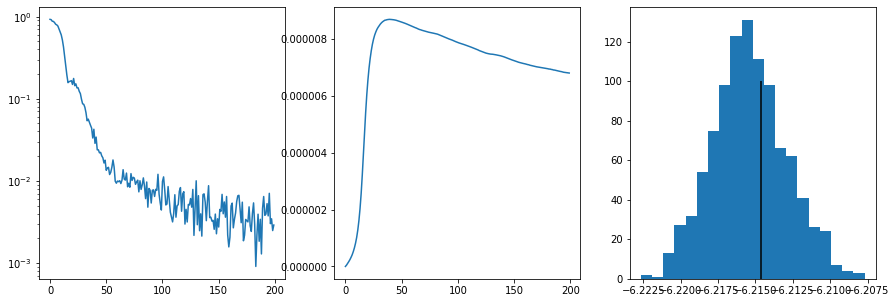

In [266]:
fig, ax = plt.subplots(figsize=(15,5),ncols=3)
ax[0].plot(gate_losses)
ax[0].set_yscale('log')
ax[1].plot(kl_losses)
ax[2].hist(obj.log_sigma.detach(),bins=20);
ax[2].vlines(obj.prior_sigma.mean(),0,100)

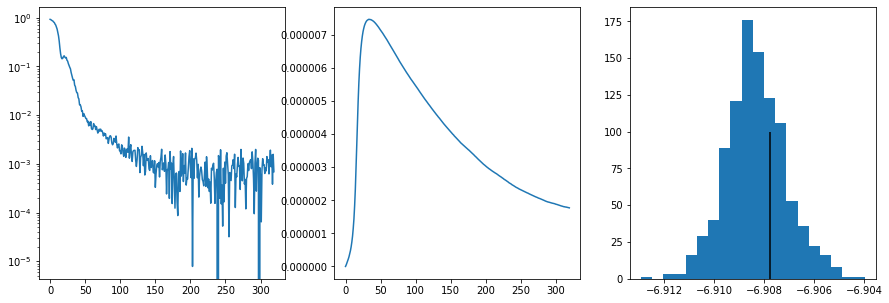

In [256]:
fig, ax = plt.subplots(figsize=(15,5),ncols=3)
ax[0].plot(gate_losses)
ax[0].set_yscale('log')
ax[1].plot(kl_losses)
ax[2].hist(obj.log_sigma.detach(),bins=20);
ax[2].vlines(obj.prior_sigma.mean(),0,100)
# ax[1].plot(obj.log_sigma.detach())

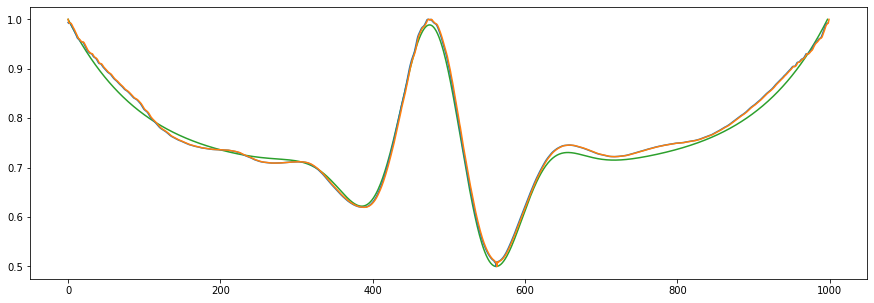

In [257]:
plt.figure(figsize=(15,5))
plt.plot(obj.restrict_output(obj.heights.detach(),0.5,1))
plt.plot(obj.restrict_diff(obj.heights.detach()))
plt.plot(obj.init_heights(),zorder=-1)

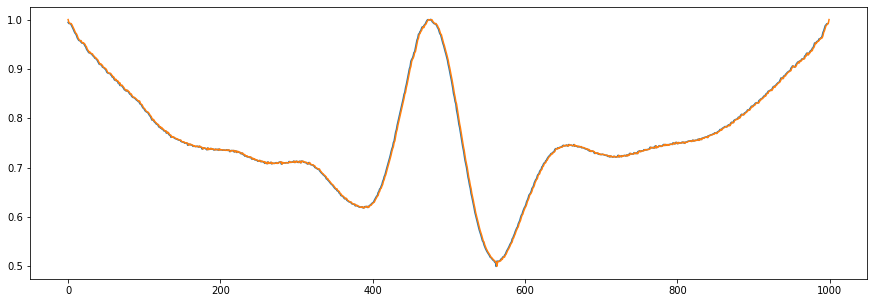

In [258]:
qz = ReparameterizedDiagonalGaussian(obj.restrict_output(obj.heights.detach(),0.5,1.0), obj.log_sigma.detach())
alphas = qz.rsample()

plt.figure(figsize=(15,5))
plt.plot(alphas)
# plt.plot(obj.heights.detach())
plt.plot(obj.restrict_diff(alphas))
# plt.plot(obj.restrict_diff(obj.heights.detach()))

In [259]:
tmp_losses = []
with torch.no_grad():
    for i in range(20):
        U, _ = obj()
        tmp_losses.append(obj.C1_gate(U).item())

In [246]:
t.std(t.log(t.tensor(tmp_losses)),unbiased=True), t.std(t.log(t.tensor(tmp_losses2)),unbiased=True)

(tensor(nan), tensor(0.7041))

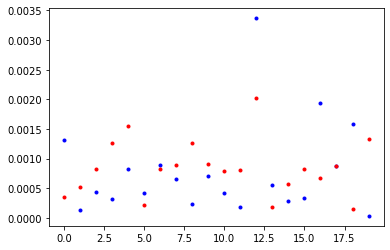

In [261]:
fig, ax = plt.subplots()
# ax.hist(tmp_losses,bins=10,range=(-0.0005,0.003))
# m1,std1 = 
ax.plot(tmp_losses,'b.')
ax.plot(tmp_losses2,'r.')

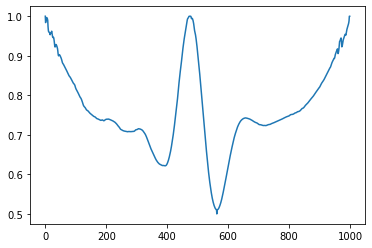

In [162]:
tmp_alphas = t.load(os.path.join(dir_path,'Experiments','Flensmon2D_7','1010_AlphaRun.pt'))
plt.plot(tmp_alphas)

In [232]:
class SavedBasis(Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.SavedBasis, Plotting.Plotter):
    def __init__(self,params_dict):
        self.params_dict = params_dict
        self.alphas = tmp_alphas
        self.sigmas = obj.log_sigma.detach().clone().exp()
        # self.control = control
        super().__init__()
        return

    def forward(self):
        alphas = self.activation_func(self.times)
        alphas = self.restrict_diff(t.normal(alphas[1:-1],self.sigmas))
        H = self.get_H(alphas)
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)

    def restrict_diff(self,heights):
        max_diff = 0.01
        out = t.zeros(heights.shape[0])
        out[0] = heights[0]
        for i in range(heights.shape[0]-1):
            diff = heights[i+1] - out[i]
            out[i+1] = out[i] + self.restrict_output(diff,0,max_diff) + self.restrict_output(diff,-max_diff,0)
        one = t.tensor([1.])
        return t.concat([one,self.restrict_output(out,0.5,1),one])

    def restrict_output(self,inp,Min,Max):
        return self.ReLU(inp - Min) - self.ReLU(inp - Max) + Min
    
SB = SavedBasis(params_dict)

I added a factor half to the cosines


In [233]:
obj.C1_gate(SB.forward())

tensor(0.0006)

In [234]:
tmp_losses2 = []
with torch.no_grad():
    for i in range(20):
        U = SB.forward()
        tmp_losses2.append(obj.C1_gate(U).item())

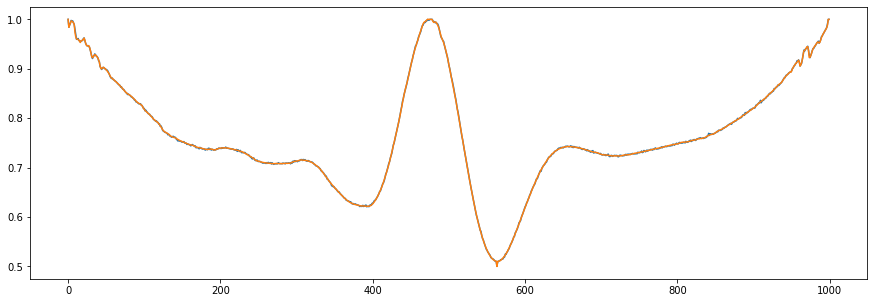

In [203]:
plt.figure(figsize=(15,5))
plt.plot(SB.restrict_diff(t.normal(SB.alphas[1:-1],obj.log_sigma.detach().clone().exp())))
plt.plot(SB.alphas)

In [235]:
tmp_losses2

[0.0003498196601867676,
 0.0005198121070861816,
 0.0008298754692077637,
 0.0012575984001159668,
 0.0015561580657958984,
 0.00021576881408691406,
 0.000825345516204834,
 0.0009014010429382324,
 0.0012673735618591309,
 0.0009145736694335938,
 0.0007928013801574707,
 0.0008137822151184082,
 0.002024710178375244,
 0.00018155574798583984,
 0.0005699992179870605,
 0.0008216500282287598,
 0.0006695985794067383,
 0.000870048999786377,
 0.00014781951904296875,
 0.0013355612754821777]

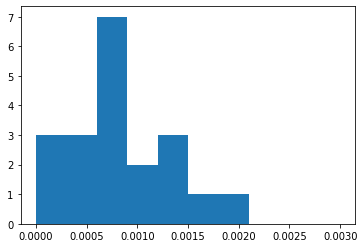

In [237]:
fig, ax = plt.subplots()
ax.hist(tmp_losses2,bins=10,range=(0,0.003));